<a href="https://colab.research.google.com/gist/mmore500/a2e88e7c239935c362ec59c6b5a3f7b5/reconstruction-quality-experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Procedure:

For each experimental replicate per treatment,
- Navigate to <https://colab.research.google.com/gist/mmore500/a2e88e7c239935c362ec59c6b5a3f7b5> to open a fresh copy of the experiment notebook. **Open a fresh notebook copy for each treatment.**
- Click on filename on the top left of the Colab page(`a2e88e7c239935c362ec59c6b5a3f7b5`) and rename according to template
  - `evo=island{num_islands}-niche{num_niches}-ngen{num_generations}-popsize{population_size}-tournsize{tournament_size}+instrument={"steady"|"tilted"}-{"old"|"new"}-bits{annotation_size_bits}-diff{differentia_width}+replicate={replicate}+ext=.ipynb`.
  - For example, `evo=island1-niche1-ngen10000-popsize1024-tournsize2+instrument=steady-old-bits64-diff1+replicate=0+ext=.ipynb`.
- Configure variables in "Configure Experment" section.
- On the top menu, click `Runtime > Restart sesson and run all` if available, otherwise `Runtime > Run all`.
- Wait for final cell's execution to complete.
- Record configured variables and results from "Evaluate Reconstruction" section in [results spreadsheet](https://docs.google.com/spreadsheets/d/1ZhS4NDTDyBiwmwtWrZO5L06MGB3lhmp2-5ZzClhEwPU/edit?usp=sharing).
- On the top menu, click `File > Download > Download .ipynb`.
- Upload ipynb file to treatment directory at <https://osf.io/n4b2g/>, named same as notebook, except excluding `+replicate={replicate}+ext=.ipynb`.
  - Treatment directory should contain notebooks for each replicate of notebook.


## Set Up Environment

In [46]:
!python3 -m pip install \
    "alifedata_phyloinformatics_convert==0.15.1" \
    "biopython==1.83" \
    "dendropy==4.6.1" \
    "git+https://github.com/mmore500/hstrat-surface-concept.git@v0.1.0#egg=hsurf" \
    "hstrat==1.9.1" \
    "matplotlib==3.8.2" \
    "pandas==1.5.3" \
    "tqdist==1.0" \
    "tqdm==4.66.1" \
    "typing_extensions>=4.9.0" \
    "watermark==2.4.3"

  Cloning https://github.com/mmore500/hstrat-surface-concept.git (to revision v0.1.0) to /tmp/pip-install-jq4n6f1x/hsurf_c1792389f64c4d64920c20ce263aa606
  Running command git clone --filter=blob:none --quiet https://github.com/mmore500/hstrat-surface-concept.git /tmp/pip-install-jq4n6f1x/hsurf_c1792389f64c4d64920c20ce263aa606
  Running command git checkout -q 0873dcb9281393fc952925fe35debec6a05c5f1e
  Resolved https://github.com/mmore500/hstrat-surface-concept.git to commit 0873dcb9281393fc952925fe35debec6a05c5f1e
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... canceledERROR: Operation cancelled by user


In [1]:
from collections import Counter
import typing

import alifedata_phyloinformatics_convert as apc
from Bio import Phylo
import dendropy as dp
from hstrat import hstrat
from hstrat import _auxiliary_lib as hstrat_aux
from hsurf import hsurf
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tqdist
from tqdm import tqdm

## Configure Experiment

Configure instrumentation. **Edit me**

In [2]:
# TODO Uncomment one...
# annotation_size_bits = 64
# annotation_size_bits = 256
# annotation_size_bits = 1024
assert annotation_size_bits.bit_count() == 1, "must be power of 2 (1, 2, 4, 8, etc.)"

# TODO Uncomment one...
# differentia_width_bits = 1
# differentia_width_bits = 8
assert differentia_width_bits.bit_count() == 1, "must be power of 2 (1, 2, 4, 8, etc.)"

# TODO Uncomment one...
# stratum_retention_algo = hstrat.depth_proportional_resolution_tapered_algo  # old impl/steady behavior
# stratum_retention_algo = hstrat.recency_proportional_resolution_curbed_algo  # old impl/tilted behavior
# stratum_retention_algo = hsurf.stratum_retention_interop_steady_algo  # new impl/steady behavior
# stratum_retention_algo = hsurf.stratum_retention_interop_tilted_sticky_algo  # new impl/tilted behavior

Configure evolutionary scale. **Edit me**

In [3]:
# TODO Uncomment one...
# population_size = 1024  # default condition
# population_size = 65536  # alternate condition
assert population_size.bit_count() == 1, "must be power of 2 (1, 2, 4, 8, etc.)"

# TODO Uncomment one...
# num_generations = 10000  # default condition
# num_generations = 100000  # alternate condition


Configure evolutionary conditions.  **Edit me**

In [4]:
# TODO Uncomment one...
# num_islands=1  # default condition
# num_islands=64  # alternate condition
assert num_islands.bit_count() == 1, "must be power of 2 (1, 2, 4, 8, etc.)"

# TODO Uncomment one...
# num_niches=1  # default condition
# num_niches=8  # alternate condition
assert num_niches.bit_count() == 1, "must be power of 2 (1, 2, 4, 8, etc.)"

# TODO Uncomment one...
# tournament_size=2  # default condition
# tournament_size=1  # alternate condition
# tournament_size=8  # alternate condition


Configure experimental replicate. **Edit me**

In [5]:
replicate =  # TODO set to a number, 0 through 19

Set up random number generator. (Do not edit.)

In [6]:
seed = hash(
  (
      replicate,
      population_size,
      num_generations,
      num_islands,
      num_niches,
      tournament_size,
  )
) % 2 ** 32

seed

2843551631

In [7]:
from hstrat._auxiliary_lib import seed_random

seed_random(seed)


Parametrize instrumentation. (Do not edit.)

In [8]:
annotation_capacity_strata = annotation_size_bits // differentia_width_bits
assert annotation_capacity_strata.bit_count() == 1, "must be power of 2 (1, 2, 4, 8, etc.)"
print(f"{annotation_capacity_strata=}")

parametrized_policy = stratum_retention_algo.Policy(
  parameterizer=hstrat.PropertyAtMostParameterizer(
    target_value=annotation_capacity_strata,
    policy_evaluator=hstrat.NumStrataRetainedUpperBoundEvaluator(
      at_num_strata_deposited=num_generations,
    ),
    param_lower_bound=2,
    param_upper_bound=1024,
  ),
)

print(f"{parametrized_policy=}")
print(f"num strata retained upper bound {parametrized_policy.CalcNumStrataRetainedUpperBound(num_generations)}")


annotation_capacity_strata=256
parametrized_policy=recency_proportional_resolution_curbed_algo.Policy(policy_spec=recency_proportional_resolution_curbed_algo.PolicySpec(size_curb=256))
num strata retained upper bound 256


/usr/local/lib/python3.10/dist-packages/hstrat/stratum_retention_strategy/stratum_retention_algorithms/recency_proportional_resolution_curbed_algo/_PolicySpec.py:28: UserWarning: Size curb set to 2, the minimum guaranteeable size limit is 8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/hstrat/stratum_retention_strategy/stratum_retention_algorithms/recency_proportional_resolution_curbed_algo/_PolicySpec.py:28: UserWarning: Size curb set to 5, the minimum guaranteeable size limit is 8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/hstrat/stratum_retention_strategy/stratum_retention_algorithms/recency_proportional_resolution_curbed_algo/_PolicySpec.py:28: UserWarning: Size curb set to 7, the minimum guaranteeable size limit is 8.
  warnings.warn(


## Setup

Helper functions.

In [9]:
def calc_tqdist_distance(
    x: pd.DataFrame,
    y: pd.DataFrame,
    progress_wrap: typing.Callable = lambda x: x,
  ) -> float:
    """Calculate dissimilarity between two trees. Used to measure how accurate
    tree reconstructions are."""
    tree_a = apc.RosettaTree(x).as_dendropy
    tree_b = apc.RosettaTree(y).as_dendropy

    # must suppress root unifurcations or tqdist barfs
    # see https://github.com/uym2/tripVote/issues/15
    tree_a.unassign_taxa(exclude_leaves=True)
    tree_a.suppress_unifurcations()
    tree_b.unassign_taxa(exclude_leaves=True)
    tree_b.suppress_unifurcations()

    tree_a_taxon_labels = [
        leaf.taxon.label for leaf in progress_wrap(tree_a.leaf_node_iter())
    ]
    tree_b_taxon_labels = [
        leaf.taxon.label for leaf in progress_wrap(tree_b.leaf_node_iter())
    ]
    all(
        progress_wrap(
          zip(tree_a.leaf_node_iter(), tree_b.leaf_node_iter(), strict=True),
        ),
    )
    assert sorted(tree_a_taxon_labels) == sorted(tree_b_taxon_labels)
    assert sorted(tree_a_taxon_labels) == sorted(
        x.loc[hstrat_aux.alifestd_find_leaf_ids(x), "taxon_label"],
      )
    assert sorted(tree_a_taxon_labels) == sorted(
        y.loc[hstrat_aux.alifestd_find_leaf_ids(y), "taxon_label"],
    )
    for taxon_label in progress_wrap(tree_a_taxon_labels):
        assert taxon_label
        assert taxon_label.strip()

    newick_a = tree_a.as_string(schema="newick").strip()
    newick_b = tree_b.as_string(schema="newick").strip()

    return {
        "quartet_distance": tqdist.quartet_distance(newick_a, newick_b),
        "quartet_distanc_raw": tqdist.quartet_distance_raw(newick_a, newick_b),
        "triplet_distance": tqdist.triplet_distance(newick_a, newick_b),
        "triplet_distance_raw": tqdist.triplet_distance_raw(newick_a, newick_b),
    }


## Generate Phylogeny

Use simple evolutionary simulation to generate a phylogenetic history to test reconstruction process on.

In [10]:
true_phylogeny_df = hstrat.evolve_fitness_trait_population(
    num_islands=num_islands,
    num_niches=num_niches,
    num_generations=num_generations,
    population_size=population_size,
    tournament_size=tournament_size,
    progress_wrap=tqdm,
)

100%|██████████| 13349/13349 [00:00<00:00, 28354.13it/s]


In [11]:
true_phylogeny_df["taxon_label"] = true_phylogeny_df["loc"].astype(str)
true_phylogeny_df = hstrat_aux.alifestd_mark_leaves(true_phylogeny_df, mutate=True)
true_phylogeny_df.loc[
    ~true_phylogeny_df["is_leaf"], "taxon_label"
] = ""
true_phylogeny_df

,id,ancestor_list,loc,trait,origin_time,island,niche,taxon_label,is_leaf
0,0,[None],0,NaN,0,0,0,,False
1,1,[0],943,0.000000,1,0,0,,False
2,2,[1],354,2.004265,2,0,0,,False
3,3,[2],274,2.408007,3,0,0,,False
4,4,[3],638,4.156169,4,0,0,,False
...,...,...,...,...,...,...,...,...,...
13344,13344,[11848],1019,10898.905273,10001,0,0,1019,True
13345,13345,[11987],1020,10899.241211,10001,0,0,1020,True
13346,13346,[12201],1021,10899.873047,10001,0,0,1021,True
13347,13347,[11826],1022,10898.057617,10001,0,0,1022,True


In [12]:
true_phylogeny_df = hstrat_aux.alifestd_to_working_format(
  hstrat_aux.alifestd_collapse_unifurcations(true_phylogeny_df, mutate=True),
  mutate=True,
).reset_index(drop=True)
true_phylogeny_df

,id,ancestor_list,loc,trait,origin_time,island,niche,taxon_label,is_leaf,ancestor_id
0,0,[none],0,NaN,0,0,0,,False,0
1,1,[0],796,10809.736328,9915,0,0,,False,0
2,2,[1],176,10854.279297,9956,0,0,,False,1
3,3,[2],890,10857.725586,9959,0,0,,False,2
4,4,[3],983,10865.136719,9965,0,0,,False,3
...,...,...,...,...,...,...,...,...,...,...
1753,1753,[259],1019,10898.905273,10001,0,0,1019,True,259
1754,1754,[411],1020,10899.241211,10001,0,0,1020,True,411
1755,1755,[672],1021,10899.873047,10001,0,0,1021,True,672
1756,1756,[490],1022,10898.057617,10001,0,0,1022,True,490


## Generate Reconstruction

Generate genome annotations as if tracking phylogeny in distributed environment.
Then run reconstruction proess to estimate true phylogeny from generated annotations.

In [13]:
extant_annotations = hstrat.descend_template_phylogeny_alifestd(
    true_phylogeny_df,
    seed_column=hstrat.HereditaryStratigraphicColumn(parametrized_policy),
    extant_ids=hstrat_aux.alifestd_find_leaf_ids(true_phylogeny_df),
    progress_wrap=tqdm,
)

len(extant_annotations)

100%|██████████| 1024/1024 [00:00<00:00, 1774.43it/s]


1024

In [14]:
reconstructed_phylogeny_df = hstrat.build_tree(
  extant_annotations,
  progress_wrap=tqdm,
  version_pin=hstrat.__version__,
  taxon_labels=true_phylogeny_df.loc[
      hstrat_aux.alifestd_find_leaf_ids(true_phylogeny_df),
      "taxon_label",
  ],
)
reconstructed_phylogeny_df

100%|██████████| 1024/1024 [00:00<00:00, 1862.72it/s]
1024it [00:00, 63844.80it/s]
4496it [00:00, 67966.30it/s]
4496it [00:00, 44097.40it/s]


,id,ancestor_list,origin_time,taxon_label,ancestor_id
0,0,[none],0.0,Root,0
111,111,[0],9913.5,Inner+r=9912+d=IoIQE02XgS_+uid=CBgehNmadJJFUNQ...,0
143,143,[111],9956.5,Inner+r=9956+d=KKB6PL3xuRg+uid=yhkI4h-y-hqs5ID...,111
146,146,[143],9958.5,Inner+r=9958+d=NrLgUYHm8lg+uid=EsVJTq2_n1cBCag...,143
158,158,[146],9964.5,Inner+r=9964+d=PcSgj5pSX-u+uid=C6LtdX4TgeEmwiD...,146
...,...,...,...,...,...
4491,4491,[1040],10001.0,872,1040
4492,4492,[794],10001.0,64,794
4493,4493,[794],10001.0,117,794
4494,4494,[2447],10001.0,714,2447


In [15]:
reconstructed_phylogeny_df = hstrat_aux.alifestd_collapse_unifurcations(reconstructed_phylogeny_df, mutate=True)
reconstructed_phylogeny_df

,id,ancestor_list,origin_time,taxon_label,ancestor_id
0,0,[none],0.0,Root,0
111,111,[0],9913.5,Inner+r=9912+d=IoIQE02XgS_+uid=CBgehNmadJJFUNQ...,0
143,143,[111],9956.5,Inner+r=9956+d=KKB6PL3xuRg+uid=yhkI4h-y-hqs5ID...,111
146,146,[143],9958.5,Inner+r=9958+d=NrLgUYHm8lg+uid=EsVJTq2_n1cBCag...,143
158,158,[146],9964.5,Inner+r=9964+d=PcSgj5pSX-u+uid=C6LtdX4TgeEmwiD...,146
...,...,...,...,...,...
4491,4491,[1040],10001.0,872,1040
4492,4492,[794],10001.0,64,794
4493,4493,[794],10001.0,117,794
4494,4494,[2447],10001.0,714,2447


## Evaluate Reconstruction

Reconstruction quality data --- collect into spreadsheet.

In [16]:
estimation_intervals = [
    hstrat.calc_ranks_since_mrca_bounds_with(
        *np.random.choice(extant_annotations, size=2, replace=False),
        prior="arbitrary",
    )

    for __ in tqdm(range(200))
]


100%|██████████| 200/200 [00:01<00:00, 172.58it/s]


In [17]:
median_abs_uncertainty = np.median([*map(np.ptp, estimation_intervals)])
mean_abs_uncertainty = np.mean([*map(np.ptp, estimation_intervals)])
f"{median_abs_uncertainty=} {mean_abs_uncertainty=}"

'median_abs_uncertainty=4.0 mean_abs_uncertainty=2.6'

In [18]:
rel_uncertainties = (
    np.array([*map(np.ptp, estimation_intervals)])
    / (np.array([*map(np.mean, estimation_intervals)]) + 1)
)
median_rel_uncertainty = np.median(rel_uncertainties)
mean_rel_uncertainty = np.mean(rel_uncertainties)
f"{median_rel_uncertainty=} {mean_rel_uncertainty=}"

'median_rel_uncertainty=0.0449438202247191 mean_rel_uncertainty=0.046761132255805665'

In [19]:
num_true_inner_nodes = hstrat_aux.alifestd_count_inner_nodes(true_phylogeny_df)
num_reconstructed_inner_nodes = hstrat_aux.alifestd_count_inner_nodes(reconstructed_phylogeny_df)
f"{num_true_inner_nodes=} {num_reconstructed_inner_nodes=}"

'num_true_inner_nodes=734 num_reconstructed_inner_nodes=734'

In [20]:
num_true_polytomies = hstrat_aux.alifestd_count_polytomies(true_phylogeny_df)
num_reconstructed_polytomies = hstrat_aux.alifestd_count_polytomies(reconstructed_phylogeny_df)
f"{num_true_polytomies=} {num_reconstructed_polytomies=}"

'num_true_polytomies=211 num_reconstructed_polytomies=211'

In [21]:
true_polytomic_index = hstrat_aux.alifestd_calc_polytomic_index(true_phylogeny_df)
reconstructed_polytomic_index = hstrat_aux.alifestd_calc_polytomic_index(reconstructed_phylogeny_df)
f"{true_polytomic_index=} {reconstructed_polytomic_index=}"

'true_polytomic_index=290 reconstructed_polytomic_index=290'

In [22]:
distances = calc_tqdist_distance(
  true_phylogeny_df,
  reconstructed_phylogeny_df,
  progress_wrap=tqdm,
)
f"{distances=}"

1024it [00:00, 128776.90it/s]
1024it [00:00, 174684.48it/s]
1024it [00:00, 113117.74it/s]
100%|██████████| 1024/1024 [00:00<00:00, 689179.60it/s]


"distances={'quartet_distance': 0.0, 'quartet_distanc_raw': 0.0, 'triplet_distance': 0.0, 'triplet_distance_raw': 0.0}"

In [23]:
sampled_triplet_distance_strict = hstrat_aux.alifestd_estimate_triplet_distance_asexual(
    true_phylogeny_df,
    reconstructed_phylogeny_df,
    taxon_label_key="taxon_label",
    confidence=0.8,
    precision=0.05,
    strict=True,
    progress_wrap=tqdm,
    mutate=True,
)
f"{sampled_triplet_distance_strict=}"

31it [00:00, 39.65it/s]


'sampled_triplet_distance_strict=0.0'

In [24]:
sampled_triplet_distance_lax = hstrat_aux.alifestd_estimate_triplet_distance_asexual(
    true_phylogeny_df,
    reconstructed_phylogeny_df,
    taxon_label_key="taxon_label",
    confidence=0.8,
    precision=0.05,
    strict=False,
    progress_wrap=tqdm,
    mutate=True,
)
f"{sampled_triplet_distance_lax=}"

31it [00:00, 35.78it/s]


'sampled_triplet_distance_lax=0.0'

## Visualize Phylogeny & Reconstruction

For validating results.

Topology only (no time).

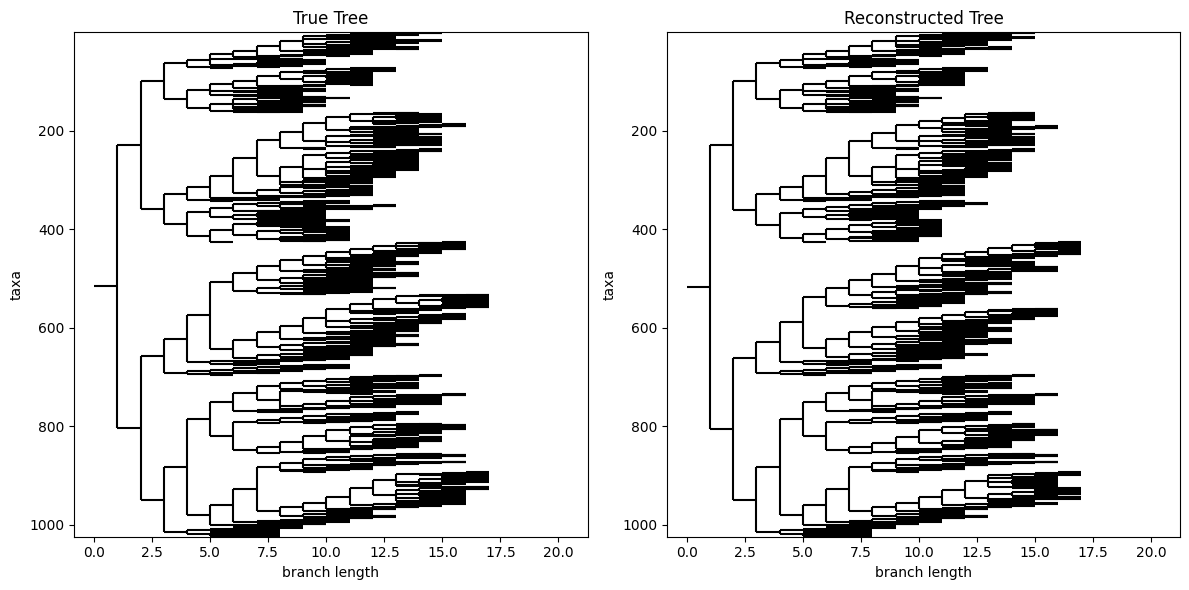

In [25]:
if population_size <= 1024:
    true_phylogeny_tree = apc.alife_dataframe_to_biopython_tree(
      hstrat_aux.alifestd_collapse_unifurcations(true_phylogeny_df),
      setup_branch_lengths=False,
    )
    reconstructed_phylogeny_tree = apc.alife_dataframe_to_biopython_tree(
      hstrat_aux.alifestd_collapse_unifurcations(reconstructed_phylogeny_df),
      setup_branch_lengths=False,
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.set_title("True Tree")
    Phylo.draw(true_phylogeny_tree, do_show=False, axes=ax1)

    ax2.set_title("Reconstructed Tree")
    Phylo.draw(reconstructed_phylogeny_tree, do_show=False, axes=ax2)

    plt.tight_layout()
    plt.show()

Scaled by time.

/usr/local/lib/python3.10/dist-packages/Bio/Phylo/_utils.py:478: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes.set_xlim(-0.05 * xmax, 1.25 * xmax)


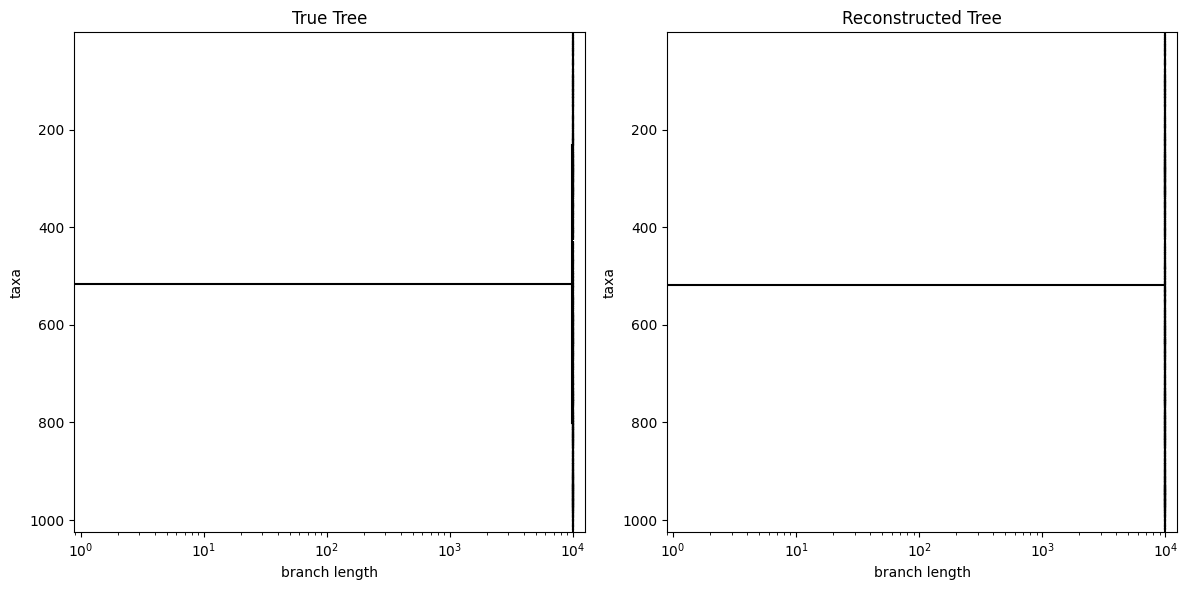

In [26]:
if population_size <= 1024:
    true_phylogeny_tree = apc.alife_dataframe_to_biopython_tree(
      hstrat_aux.alifestd_collapse_unifurcations(true_phylogeny_df),
      setup_branch_lengths=True,
    )
    reconstructed_phylogeny_tree = apc.alife_dataframe_to_biopython_tree(
      hstrat_aux.alifestd_collapse_unifurcations(reconstructed_phylogeny_df),
      setup_branch_lengths=True,
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.set_title("True Tree")
    ax1.set_xscale("log")
    Phylo.draw(true_phylogeny_tree, do_show=False, axes=ax1)

    ax2.set_title("Reconstructed Tree")
    ax2.set_xscale("log")
    Phylo.draw(reconstructed_phylogeny_tree, do_show=False, axes=ax2)

    plt.tight_layout()
    plt.show()

## Reproducibility Information

For future reference if reproducing experiments.

In [27]:
print(
  f"""# instrumentation
{annotation_size_bits=}
{differentia_width_bits=}
{stratum_retention_algo.PolicySpec.GetAlgoTitle()=}

# evolutionary scale
{population_size=}
{num_generations=}

# evolutionary conditions
{num_islands=}
{num_niches=}
{tournament_size=}
"""
)

# instrumentation
annotation_size_bits=256
differentia_width_bits=1
stratum_retention_algo.PolicySpec.GetAlgoTitle()='Curbed Recency-proportional Resolution Stratum Retention Algorithm'

# evolutionary scale
population_size=1024
num_generations=10000

# evolutionary conditions
num_islands=1
num_niches=1
tournament_size=2



In [28]:
import datetime
datetime.datetime.now().isoformat()

'2024-01-28T21:36:51.750958'

In [29]:
%load_ext watermark
%watermark

Last updated: 2024-01-28T21:36:51.778599+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.58+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [30]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.1
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
alifedata-phyloinformatics-convert==0.15.1
altair==4.2.2
anyio==3.7.1
anytree==2.12.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.11.2
bidict==0.22.1
bigframes==0.19.2
biopython==1.83
bitarray==2.9.2
bitstring==4.1.4
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.3
bqplot==0.12.42
branca==0.7.0
build==1.0.3
CacheControl==0.13.1
cachetools==5.3.2
catalogue==2.0.10
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.7
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.0
colorcet==3.0.1
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1

In [31]:
locals()

{'__name__': '__main__',
 '__doc__': 'Automatically created module for IPython interactive environment',
 '__package__': None,
 '__loader__': None,
 '__spec__': None,
 '__builtin__': <module 'builtins' (built-in)>,
 '__builtins__': <module 'builtins' (built-in)>,
 '_ih': ['',
  'from collections import Counter\nimport typing\n\nimport alifedata_phyloinformatics_convert as apc\nfrom Bio import Phylo\nimport dendropy as dp\nfrom hstrat import hstrat\nfrom hstrat import _auxiliary_lib as hstrat_aux\nfrom hsurf import hsurf\nfrom matplotlib import pyplot as plt\nimport numpy as np\nimport pandas as pd\nimport tqdist\nfrom tqdm import tqdm',
  '# TODO Uncomment one...\n# annotation_size_bits = 64\nannotation_size_bits = 256\n# annotation_size_bits = 1024\nassert annotation_size_bits.bit_count() == 1, "must be power of 2 (1, 2, 4, 8, etc.)"\n\n# TODO Uncomment one...\ndifferentia_width_bits = 1\n# differentia_width_bits = 8\nassert differentia_width_bits.bit_count() == 1, "must be power of 2